<a href="https://colab.research.google.com/github/dp1500/DrivenData-Dengue-prediction-compi/blob/main/Dengue_Prediction_ML_Comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.integrate import cumtrapz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# Set Seaborn style for the plots
sns.set(style="whitegrid")

# Loading DATA

In [ ]:
#Train Data
rawfeats = pd.read_csv('/content/dengue_features_train.csv')
rawlabels = pd.read_csv('/content/dengue_labels_train.csv')
rawfeats['total_cases'] = rawlabels['total_cases']
print(rawfeats.shape)

#Test Data
testfeats = pd.read_csv('/content/dengue_features_test.csv')
print(testfeats.shape)

# Combine train features and labels (you can skip test features if not necessary)
combined = rawfeats.copy()
combined['total_cases'] = rawlabels['total_cases']

(1456, 25)
(416, 24)


In [ ]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

## Cleaning data

In [ ]:
# Apply week adjustments to combined dataset
combined.loc[:, 'weekofyear_fixed'] = combined['weekofyear']
for year in [1993, 1994, 1995, 1999, 2000, 2005, 2006]:
    combined.loc[(combined['city'] == 'sj') & (combined['year'] == year), 'weekofyear_fixed'] += 1

# Reduce week values over 52 down to 1
combined.loc[:, 'weekofyear_fixed'] = np.where(combined['weekofyear_fixed'] > 52, 1, combined['weekofyear_fixed'])

# Check solution for San Juan
sj_test_years = combined[combined['city'] == 'sj']['year'].unique()
for year in sj_test_years:
    print(f'San Juan {year} max: {max(combined[(combined.city == "sj") & (combined.year == year)]["weekofyear_fixed"])}\
  | min: {min(combined[(combined.city == "sj") & (combined.year == year)]["weekofyear_fixed"])}\
  | uniques: {combined[(combined.city == "sj") & (combined.year == year)]["weekofyear_fixed"].nunique()}')

# Split by city
sj = combined[combined.city == 'sj'].copy()
iq = combined[combined.city == 'iq'].copy()
print(sj.shape)
print(iq.shape)

San Juan 1990 max: 52  | min: 18  | uniques: 35
San Juan 1991 max: 52  | min: 1  | uniques: 52
San Juan 1992 max: 52  | min: 1  | uniques: 52
San Juan 1993 max: 52  | min: 1  | uniques: 52
San Juan 1994 max: 52  | min: 1  | uniques: 52
San Juan 1995 max: 52  | min: 1  | uniques: 52
San Juan 1996 max: 52  | min: 1  | uniques: 52
San Juan 1997 max: 52  | min: 1  | uniques: 52
San Juan 1998 max: 52  | min: 1  | uniques: 52
San Juan 1999 max: 52  | min: 1  | uniques: 52
San Juan 2000 max: 52  | min: 1  | uniques: 52
San Juan 2001 max: 52  | min: 1  | uniques: 52
San Juan 2002 max: 52  | min: 1  | uniques: 52
San Juan 2003 max: 52  | min: 1  | uniques: 52
San Juan 2004 max: 52  | min: 1  | uniques: 52
San Juan 2005 max: 52  | min: 1  | uniques: 52
San Juan 2006 max: 52  | min: 1  | uniques: 52
San Juan 2007 max: 52  | min: 1  | uniques: 52
San Juan 2008 max: 17  | min: 1  | uniques: 17
(936, 26)
(520, 26)


# EDA

## Dengue cases by week for two cities

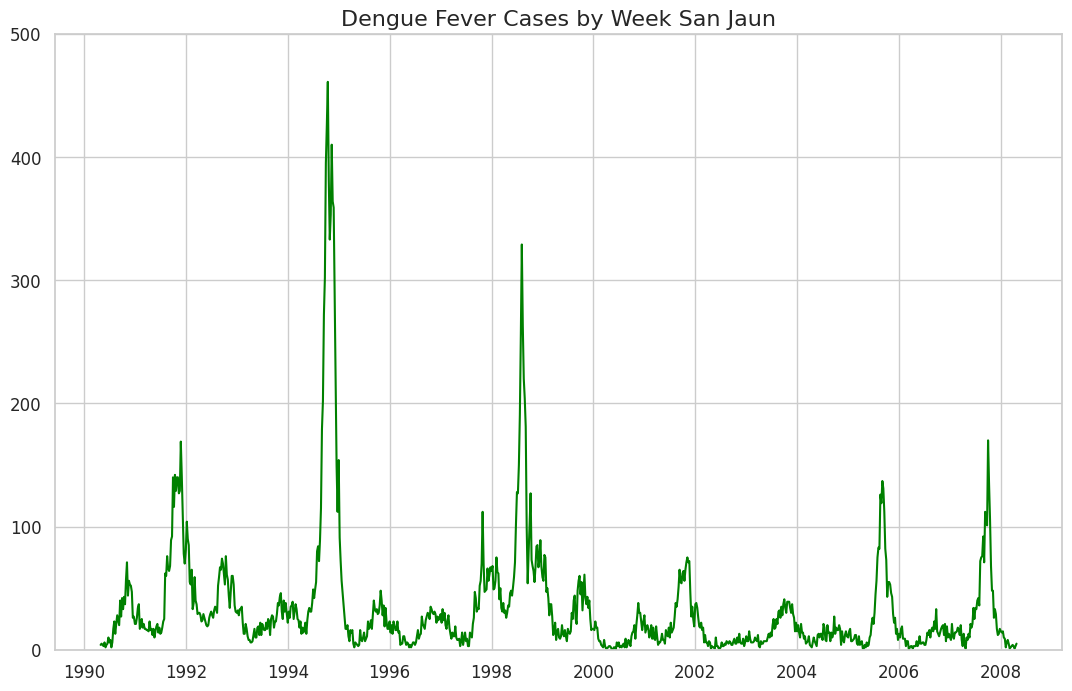

In [ ]:
plt.figure(figsize=[13,8])
plt.title('Dengue Fever Cases by Week San Jaun', size=16)
plt.plot(pd.to_datetime(sj.week_start_date), sj.total_cases, color='green')
#plt.xlim(['1990-01-01','2013-12-31' ])
plt.ylim([0,500])
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()


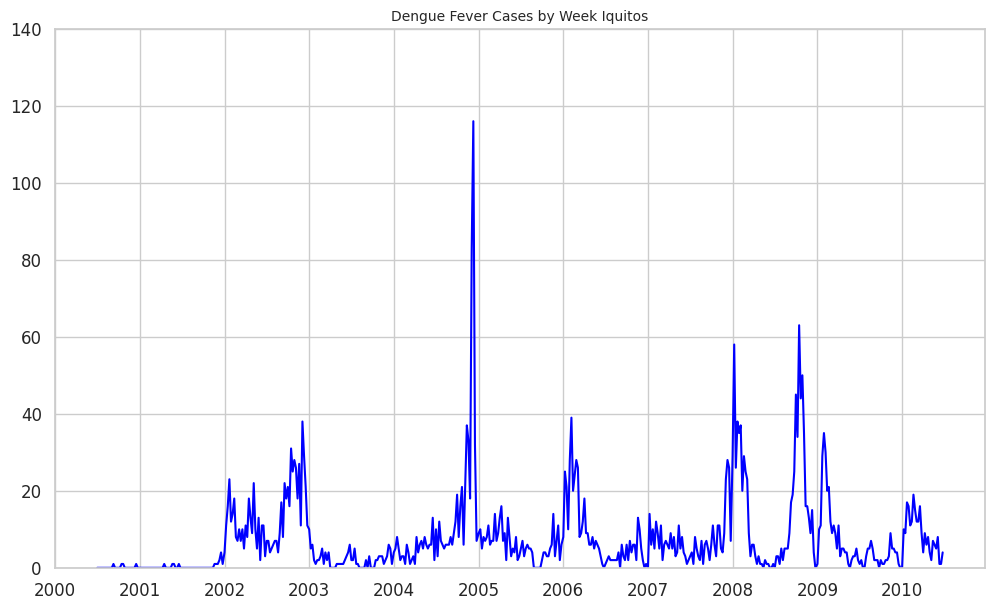

In [ ]:
plt.figure(figsize=[12,7])
plt.title('Dengue Fever Cases by Week Iquitos', size=10)
plt.plot(pd.to_datetime(iq.week_start_date), iq.total_cases, color='blue')
#plt.xlim(['1990-01-01','2013-12-31' ])
plt.ylim([0,140])
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

## Seasonality Analysis

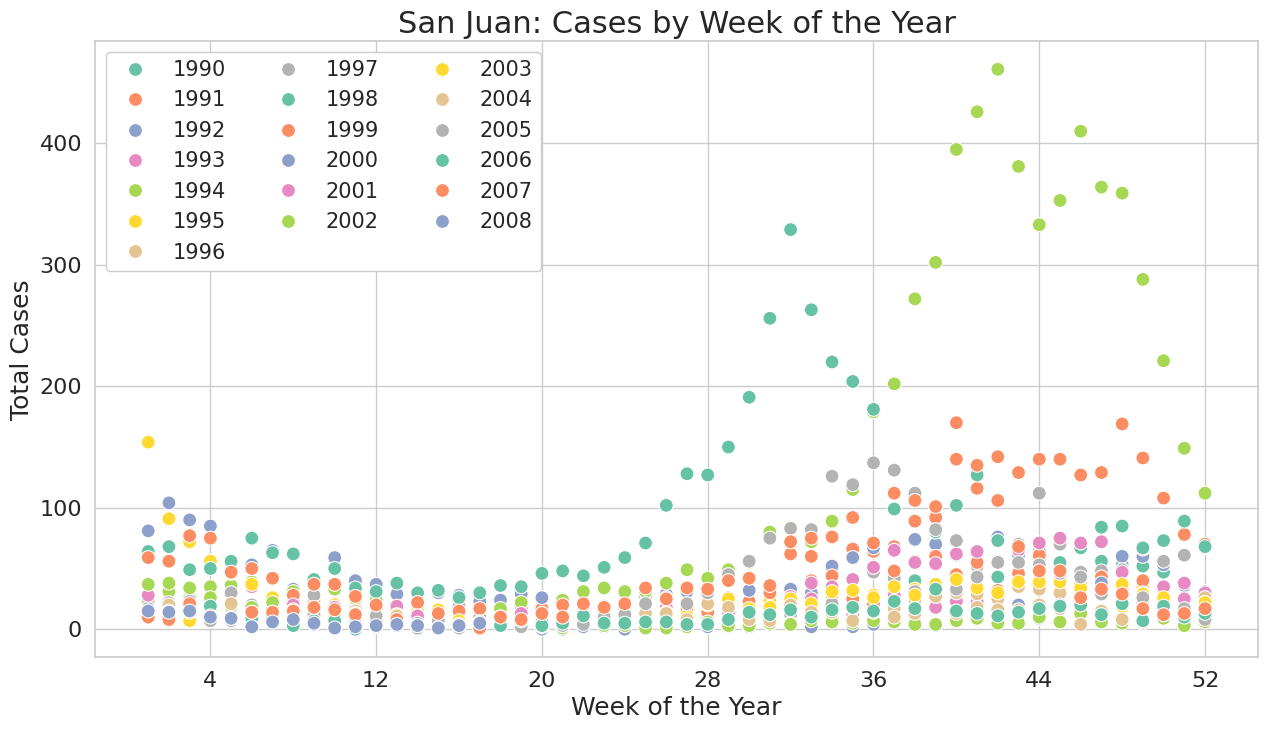

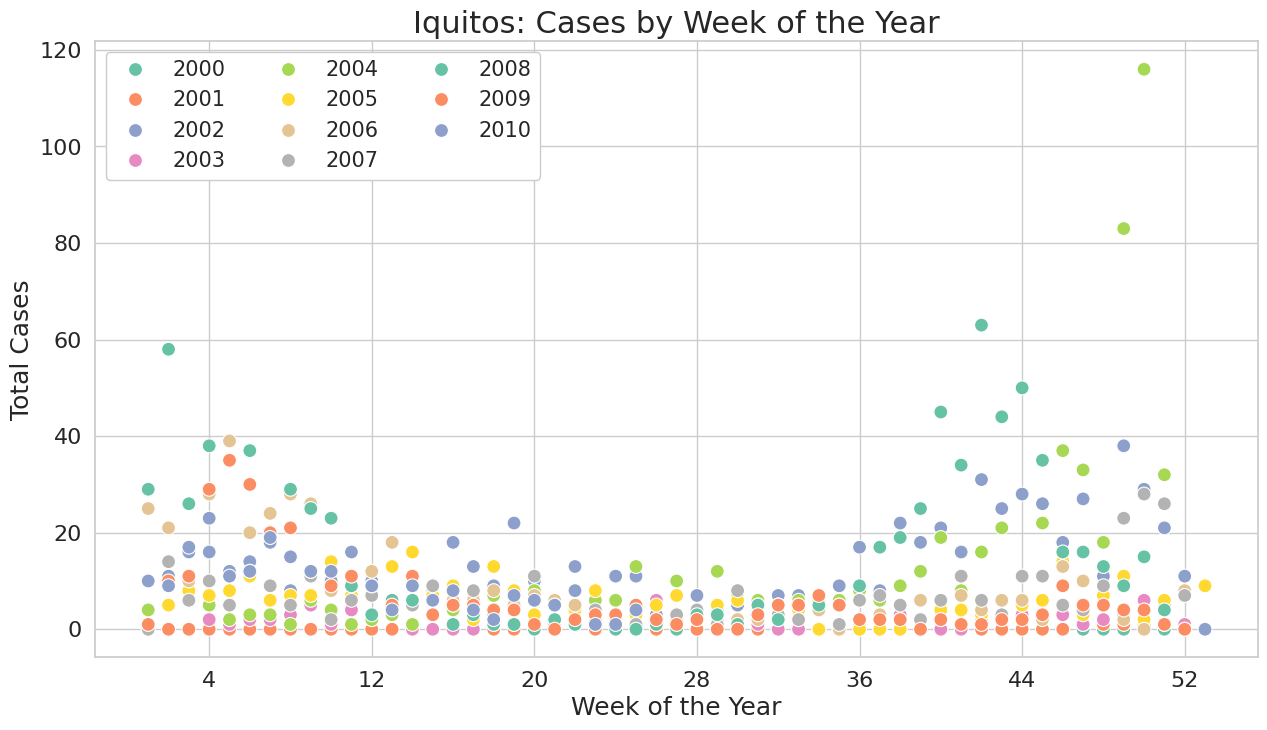

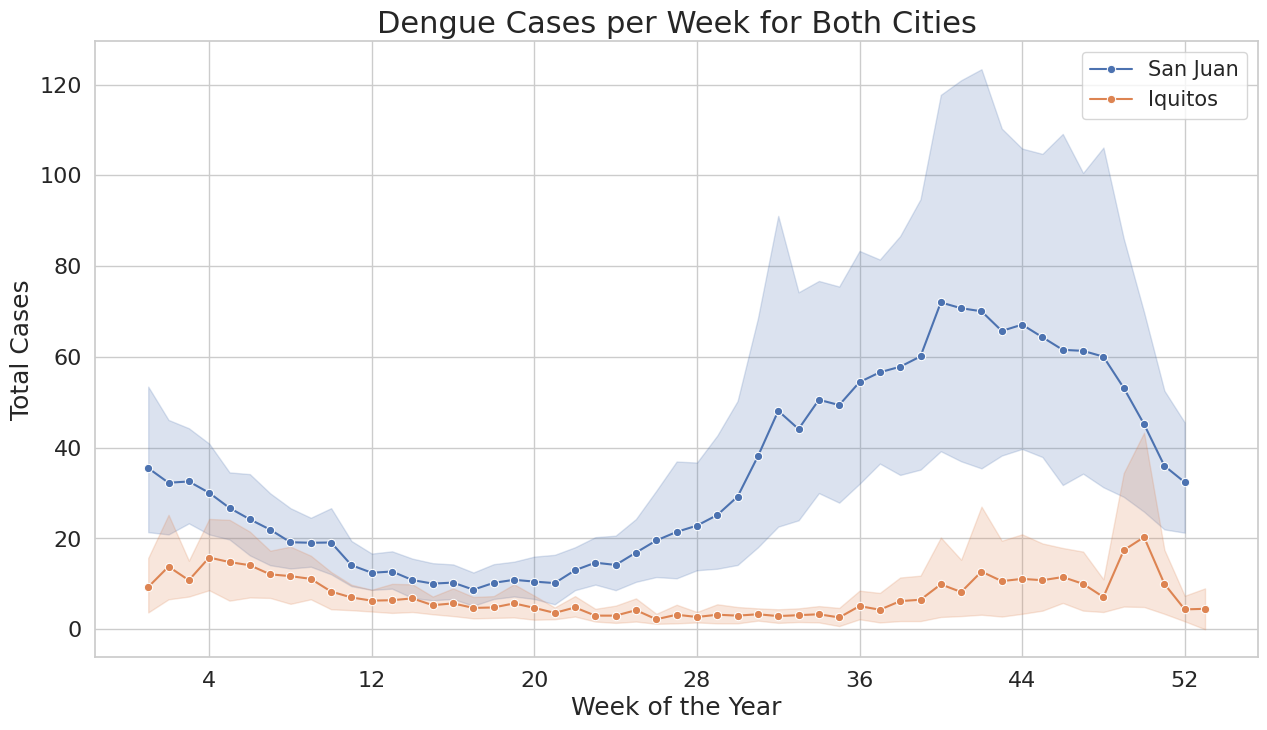

In [ ]:

def seasonality_analysis(data, city_name):
    plt.figure(figsize=[15, 8])
    plt.title(f'{city_name}: Cases by Week of the Year', size=22)
    sns.scatterplot(x='weekofyear_fixed' if city_name == 'San Juan' else 'weekofyear',
                    y='total_cases', hue='year', s=100, data=data, palette='Set2', legend='full')
    plt.legend(loc=2, framealpha=1, ncol=3, prop={'size': 15})
    plt.ylabel('Total Cases', size=18)
    plt.xlabel('Week of the Year', size=18)
    plt.xticks([4, 12, 20, 28, 36, 44, 52], size=16)
    plt.yticks(size=16)
    plt.show()

# Seasonality Analysis for San Juan
seasonality_analysis(sj, 'San Juan')

# Seasonality Analysis for Iquitos
seasonality_analysis(iq, 'Iquitos')

# Dengue Cases per Week for Both Cities
def cases_per_week(data_sj, data_iq):
    plt.figure(figsize=[15, 8])
    sns.lineplot(data=data_sj, x='weekofyear_fixed', y='total_cases', label='San Juan', marker='o')
    sns.lineplot(data=data_iq, x='weekofyear', y='total_cases', label='Iquitos', marker='o')
    plt.title('Dengue Cases per Week for Both Cities', size=22)
    plt.xlabel('Week of the Year', size=18)
    plt.ylabel('Total Cases', size=18)
    plt.xticks([4, 12, 20, 28, 36, 44, 52], size=16)
    plt.yticks(size=16)
    plt.legend(loc='upper right', prop={'size': 15})
    plt.show()

# Plot Dengue Cases per Week for Both Cities
cases_per_week(sj, iq)


Based On this visualisation maybe we can create features like season 1, season 2 etc to model dengue cases based on trends over certain weeks. Example: week 1- week 12 as one season (drawdown period of dengue cases), week 12-23 (period with lowest dengue cases for San Jaun)



## Features Analysis


Temperature EDA for San Juan


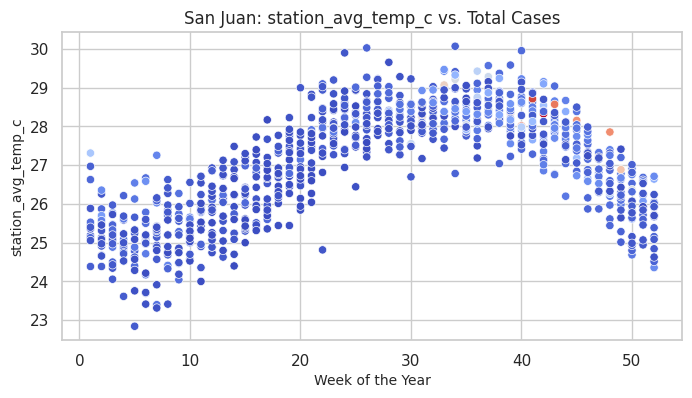

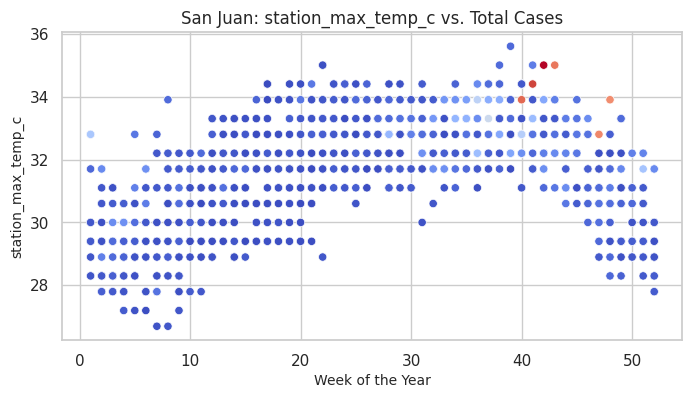

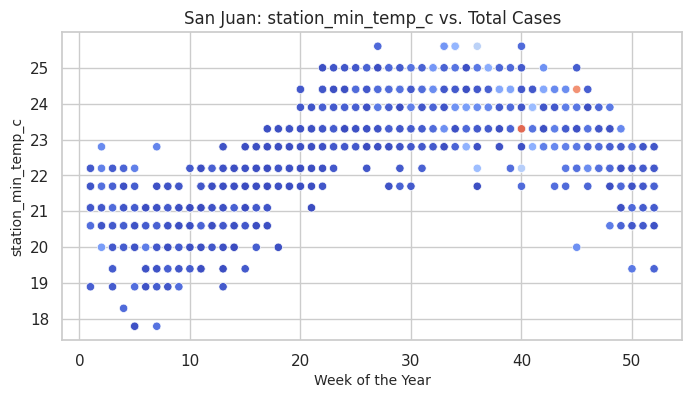

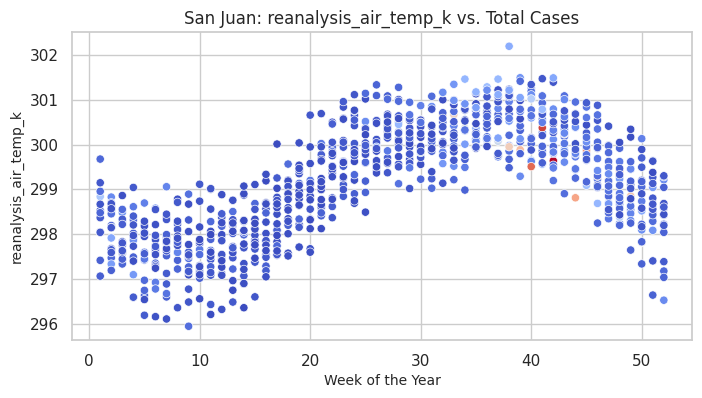

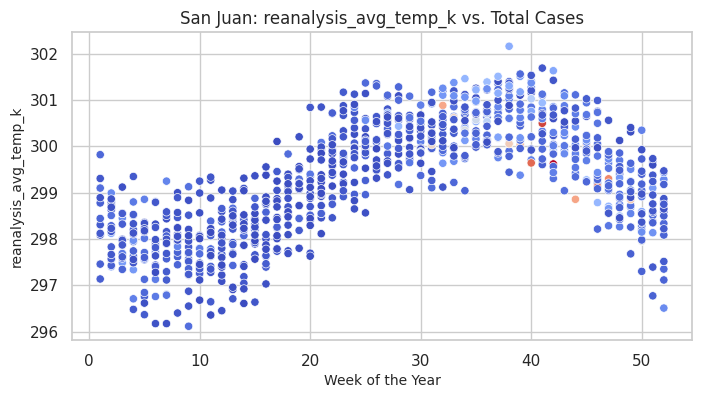

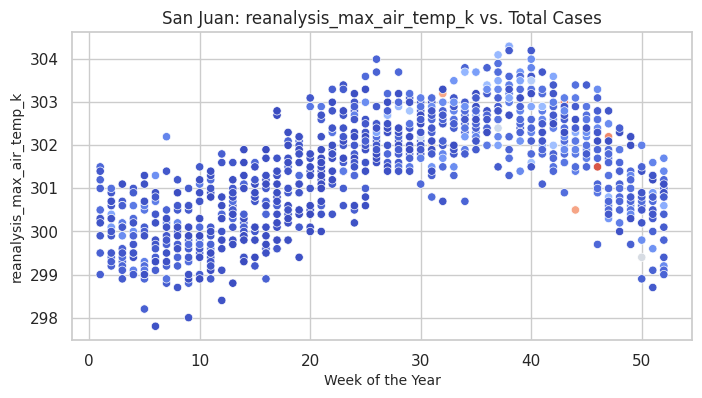

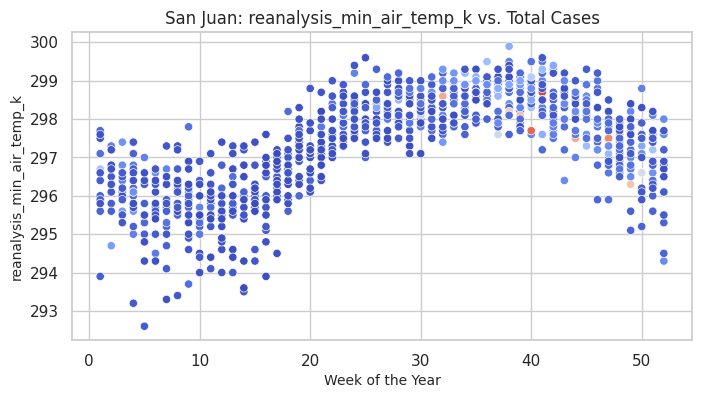

In [ ]:
# Define temperature features
temperature_features = [
    'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c',
    'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
    'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k'
]


# EDA for Temperature
def eda_temperature(data, city_name):
    for feature in temperature_features:
        plt.figure(figsize=(8, 4))
        plt.title(f'{city_name}: {feature} vs. Total Cases', size=12)
        sns.scatterplot(data=data, x='weekofyear_fixed', y=feature, hue='total_cases', palette='coolwarm')
        plt.xlabel('Week of the Year', size=10)
        plt.ylabel(feature, size=10)
        plt.legend([],[], frameon=False)
        plt.show()

# Apply EDA for Temperature
print("Temperature EDA for San Juan")
eda_temperature(sj, 'San Juan')


Temperature EDA for Iquitos


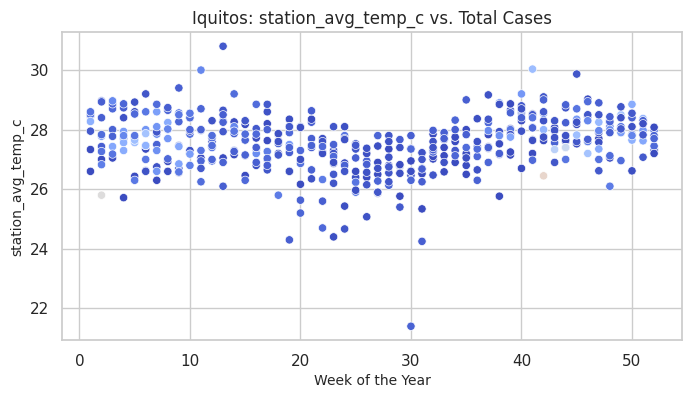

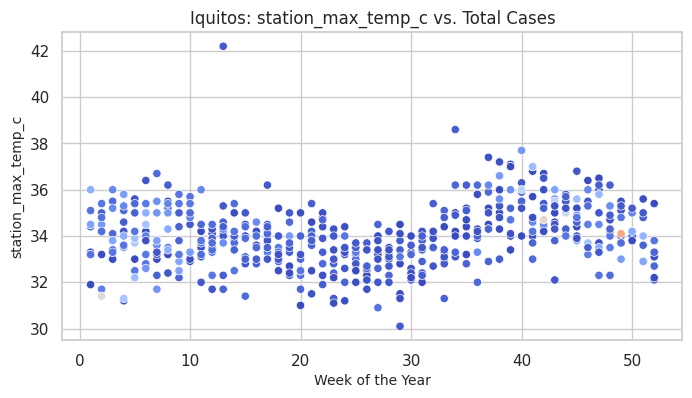

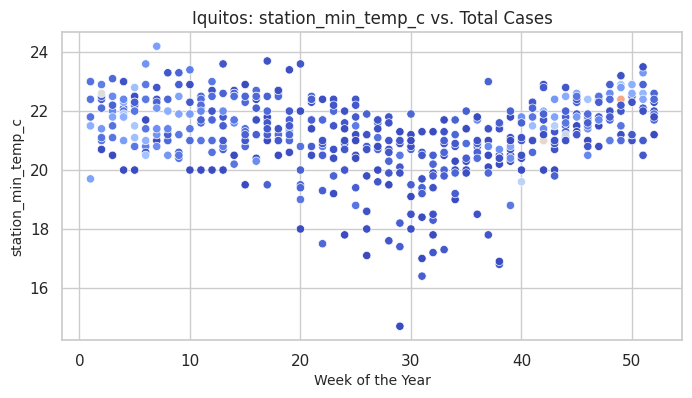

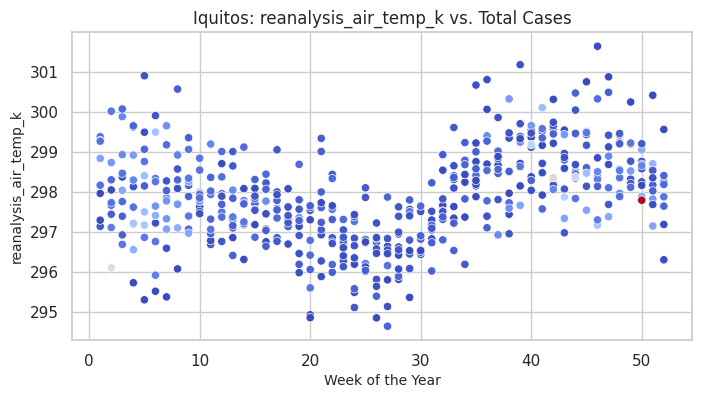

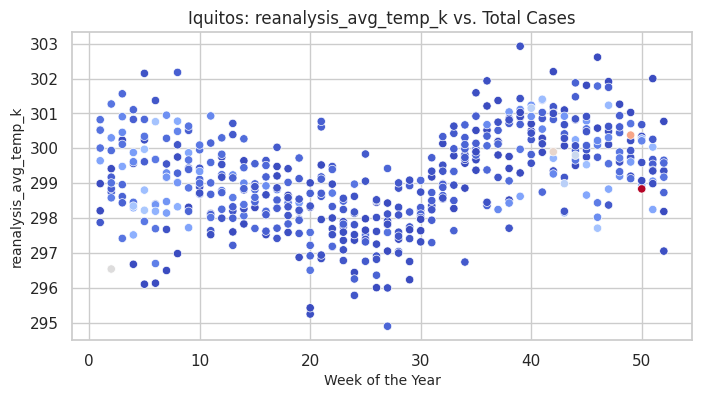

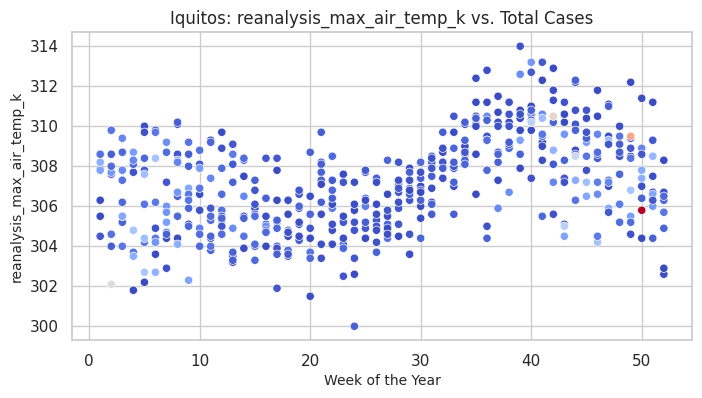

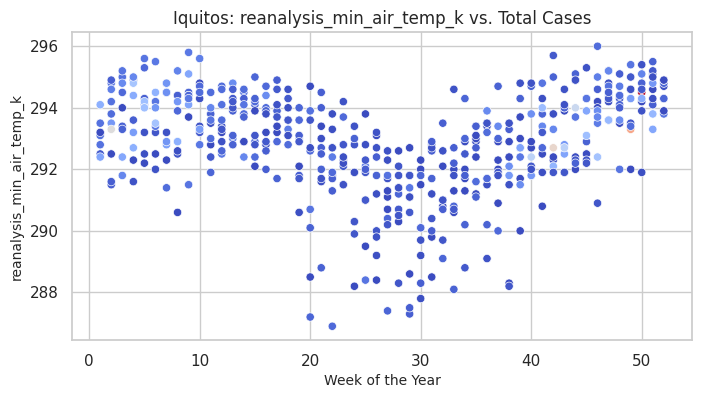

In [ ]:

print("Temperature EDA for Iquitos")
eda_temperature(iq, 'Iquitos')

- Temperature seems to be an important as cases seem to vary with it (expectedly)
- For both the cities it seems all temperature based features vary similarly (based on the respective cities data) so maybe we can just take a scaled mean of all temperature features to represent them to reduce model complexity later

Humidity EDA for San Juan


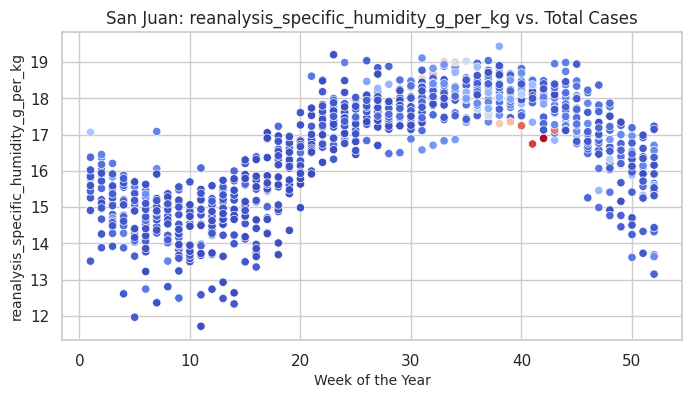

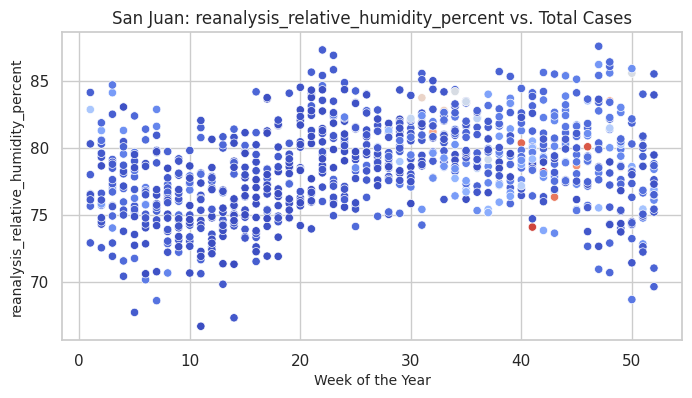

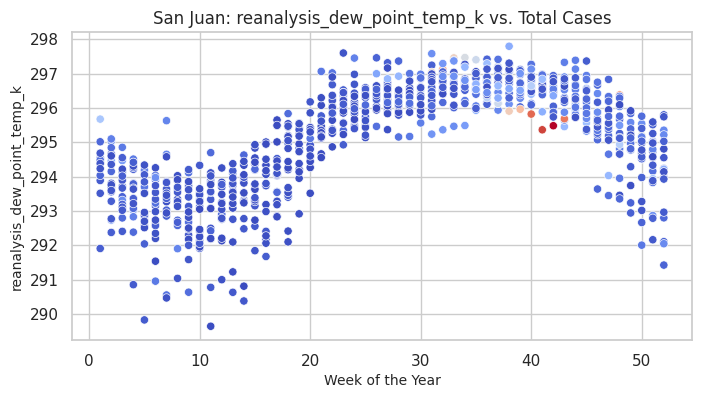

In [ ]:

# Define humidity features
humidity_features = [
    'reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent',
    'reanalysis_dew_point_temp_k'
]

# EDA for Humidity
def eda_humidity(data, city_name):
    for feature in humidity_features:
        plt.figure(figsize=(8, 4))
        plt.title(f'{city_name}: {feature} vs. Total Cases', size=12)
        sns.scatterplot(data=data, x='weekofyear_fixed', y=feature, hue='total_cases', palette='coolwarm')
        plt.xlabel('Week of the Year', size=10)
        plt.ylabel(feature, size=10)
        plt.legend([],[], frameon=False)
        plt.show()



# Apply EDA for Humidity
print("Humidity EDA for San Juan")
eda_humidity(sj, 'San Juan')



The humidity measurements appear to be useful and one is a more volatile version of the other.

Precipitation EDA for San Juan


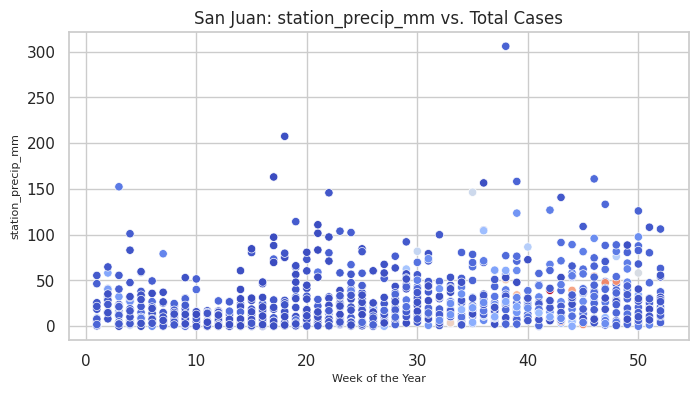

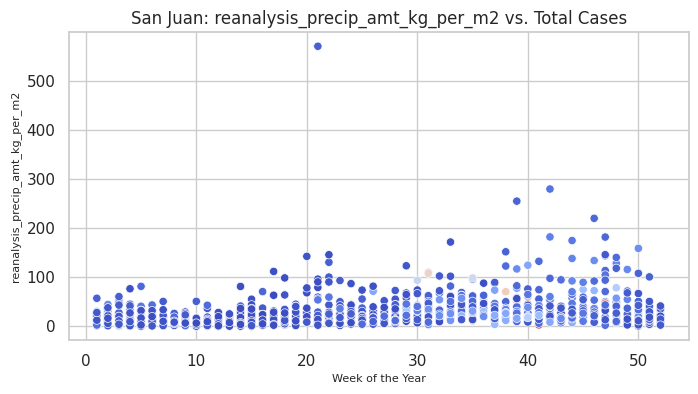

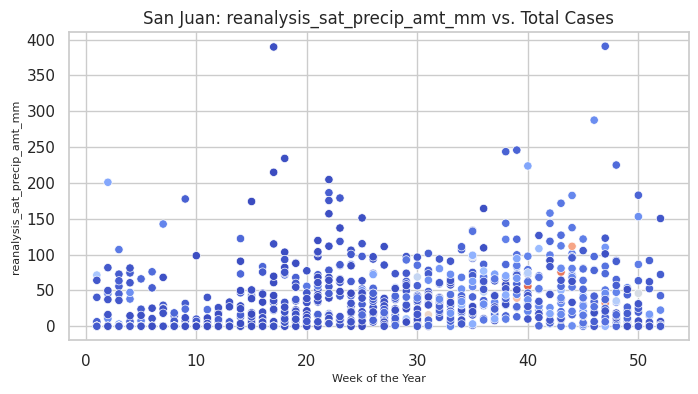

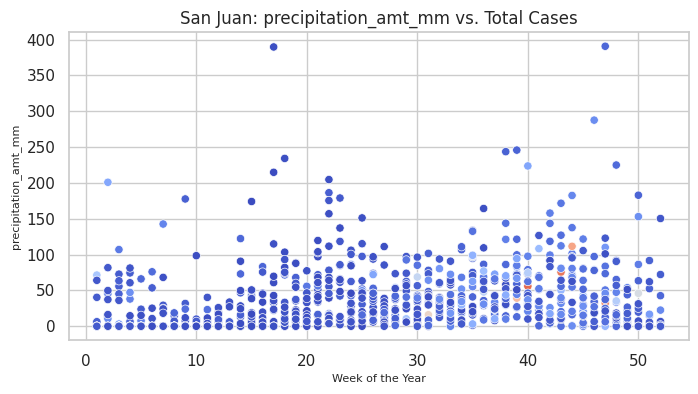

In [ ]:


# Define precipitation features
precipitation_features = [
    'station_precip_mm', 'reanalysis_precip_amt_kg_per_m2',
    'reanalysis_sat_precip_amt_mm', 'precipitation_amt_mm'
]

# EDA for Precipitation
def eda_precipitation(data, city_name):
    for feature in precipitation_features:
        plt.figure(figsize=(8, 4))
        plt.title(f'{city_name}: {feature} vs. Total Cases', size=12)
        sns.scatterplot(data=data, x='weekofyear_fixed', y=feature, hue='total_cases', palette='coolwarm')
        plt.xlabel('Week of the Year', size=8)
        plt.ylabel(feature, size=8)
        plt.legend([],[], frameon=False)
        plt.show()


# Apply EDA for Precipitation
print("Precipitation EDA for San Juan")
eda_precipitation(sj, 'San Juan')



Precipitation EDA for Iquitos


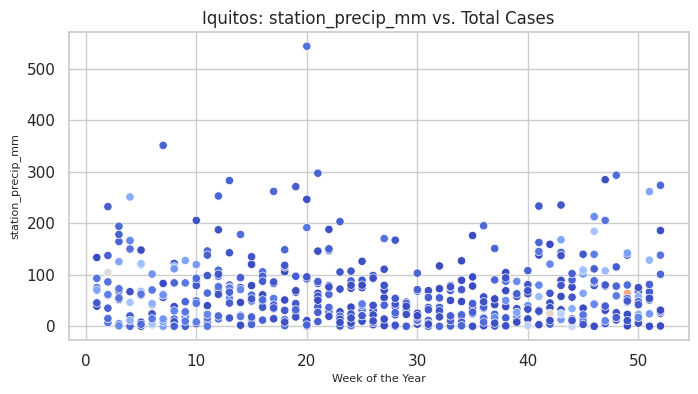

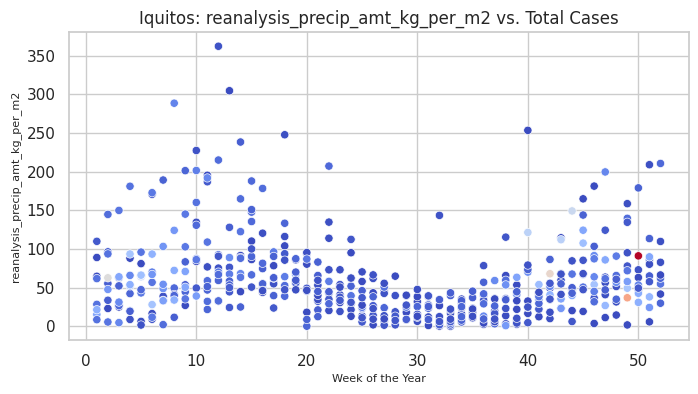

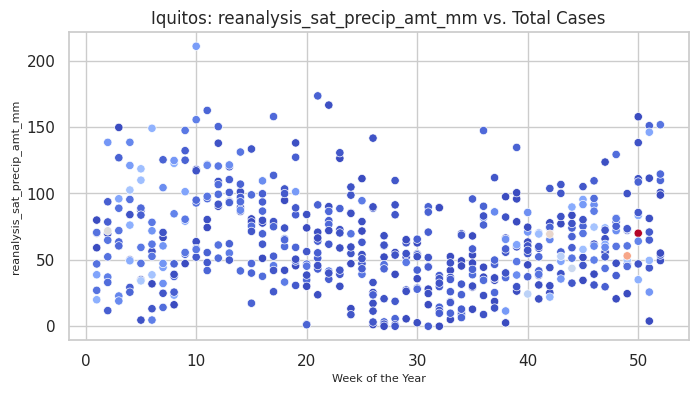

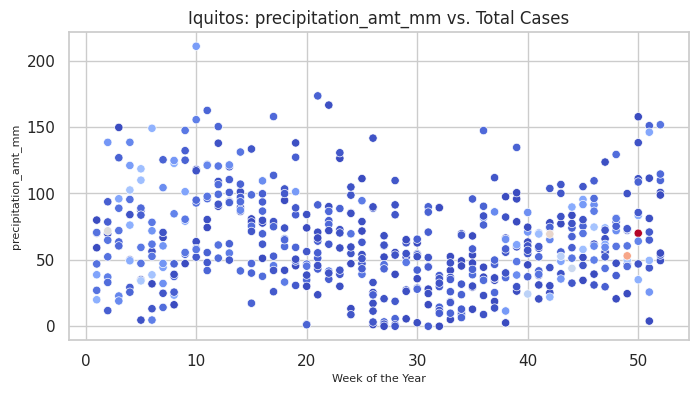

In [ ]:

print("Precipitation EDA for Iquitos")
eda_precipitation(iq, 'Iquitos')

Vegetation EDA for San Juan


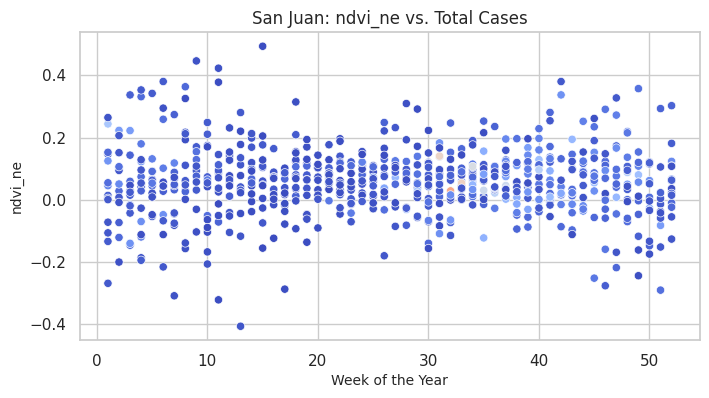

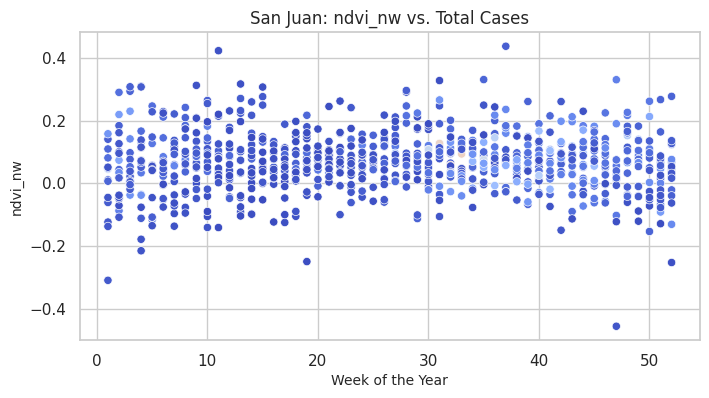

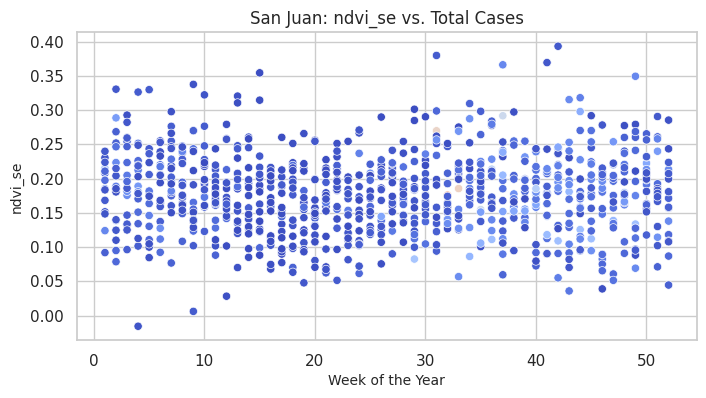

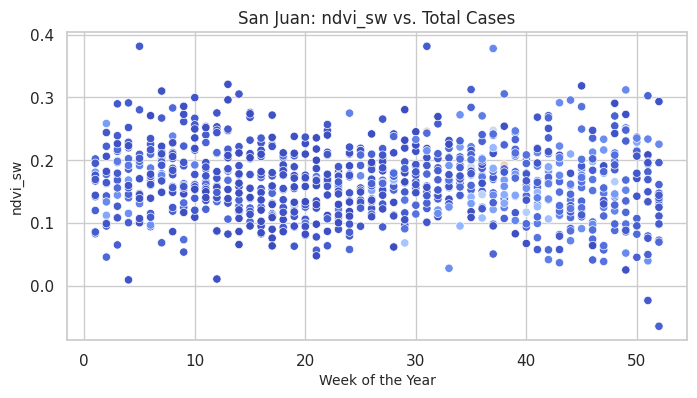

In [ ]:
# Define vegetation features
vegetation_features = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']

# EDA for Vegetation
def eda_vegetation(data, city_name):
    for feature in vegetation_features:
        plt.figure(figsize=(8, 4))
        plt.title(f'{city_name}: {feature} vs. Total Cases', size=12)
        sns.scatterplot(data=data, x='weekofyear_fixed', y=feature, hue='total_cases', palette='coolwarm')
        plt.xlabel('Week of the Year', size=10)
        plt.ylabel(feature, size=10)
        plt.legend([],[], frameon=False)
        plt.show()

# Apply EDA for Vegetation
print("Vegetation EDA for San Juan")
eda_vegetation(sj, 'San Juan')


Vegetation EDA for Iquitos


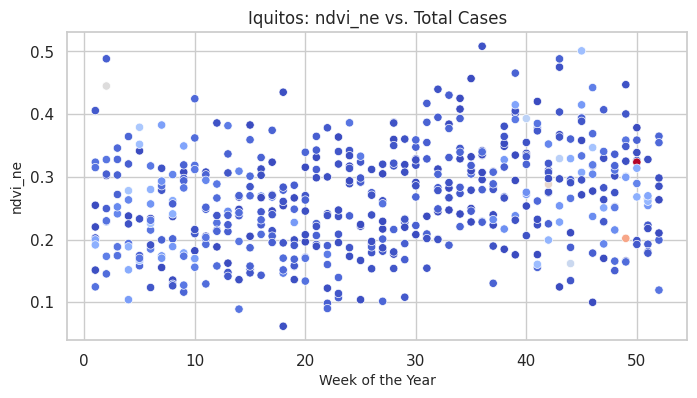

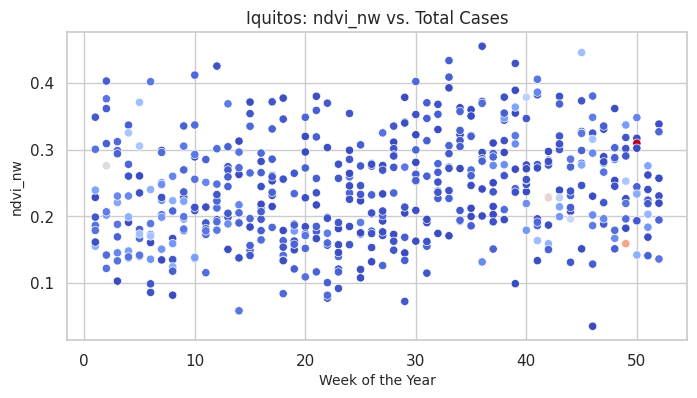

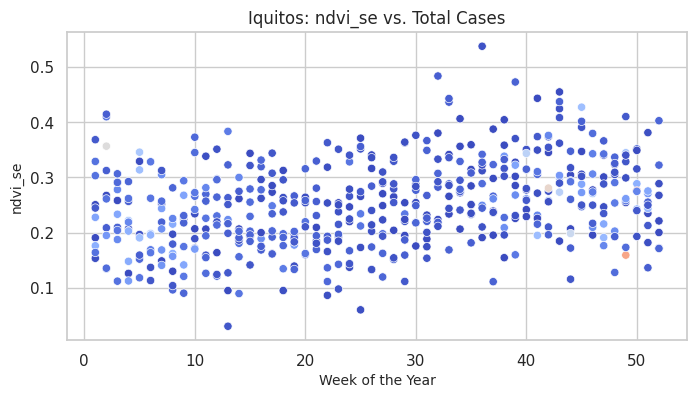

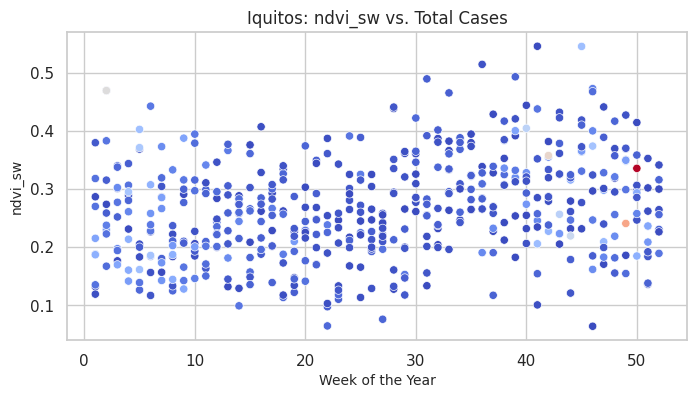

In [ ]:

print("Vegetation EDA for Iquitos")
eda_vegetation(iq, 'Iquitos')

Not much Variation in these vegetation based features so maybe we can leave them out from modelling

## Corelation before feature engineered data

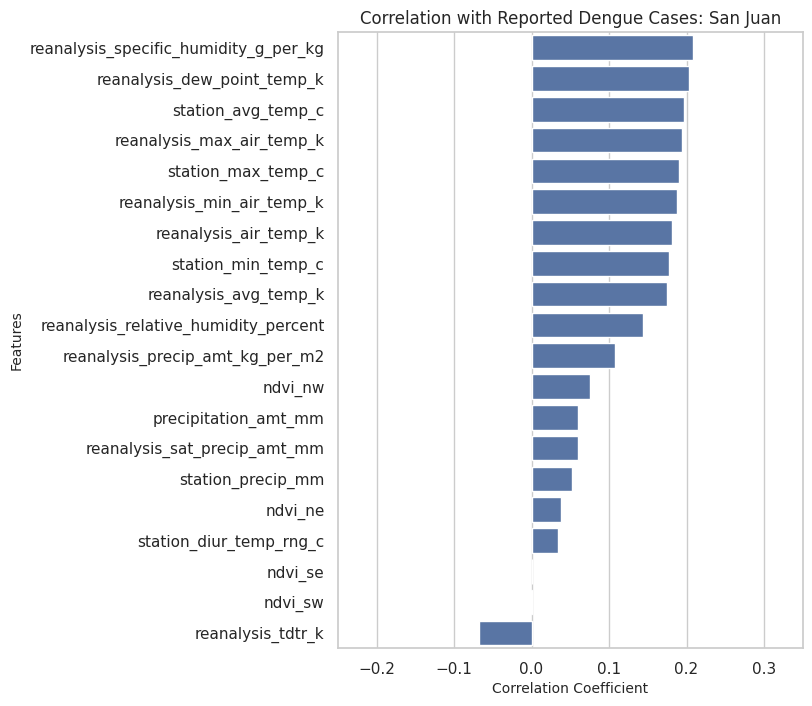

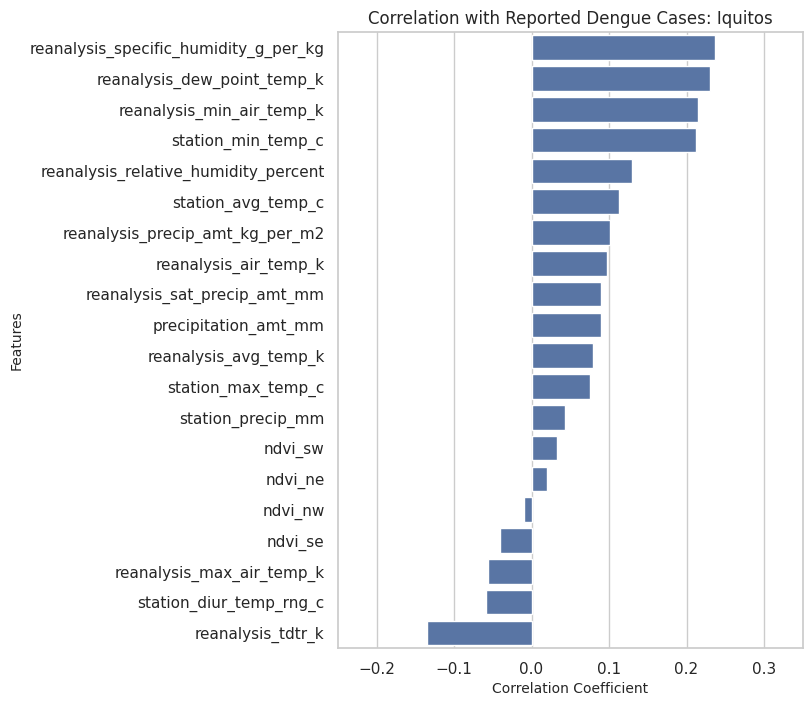

In [ ]:
# Drop the 'city' column and calculate correlation for San Juan
sjcorr = (rawfeats[rawfeats.city == 'sj']
          .drop(['city', 'week_start_date'], axis=1)
          .corr()
          .total_cases
          .drop(['total_cases', 'weekofyear', 'year'], axis=0)
          .sort_values(ascending=False))

# Drop the 'city' column and calculate correlation for Iquitos
iqcorr = (rawfeats[rawfeats.city == 'iq']
          .drop(['city', 'week_start_date'], axis=1)
          .corr()
          .total_cases
          .drop(['total_cases', 'weekofyear', 'year'], axis=0)
          .sort_values(ascending=False))

# Plot correlations for San Juan
plt.figure(figsize=[6, 8])
plt.title('Correlation with Reported Dengue Cases: San Juan', size=12)
sns.barplot(x=sjcorr, y=sjcorr.index)
plt.xlim([-.25, .35])
plt.xlabel('Correlation Coefficient', size=10)
plt.ylabel('Features', size=10)
plt.show()

# Plot correlations for Iquitos
plt.figure(figsize=[6, 8])
plt.title('Correlation with Reported Dengue Cases: Iquitos', size=12)
sns.barplot(x=iqcorr, y=iqcorr.index)
plt.xlim([-.25, .35])
plt.xlabel('Correlation Coefficient', size=10)
plt.ylabel('Features', size=10)
plt.show()


original features dont seem to have strong Pearson correlations with the total cases target variable, but we can still use them to model cases or create more meaningful features. I will consider feature with corelation greater than 0.1

# Feature Engineering for two cities

## San Jaun

In [ ]:
sj = rawfeats[rawfeats.city=='sj'].copy()
print(sj.shape)

(936, 25)


In [ ]:
def process_SJ(rawfeats, train=True):
    '''Returns a San Juan dataset ready for training or prediction'''
    #Fix Week Numbers
    if train:
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==1993,
                                                    rawfeats.weekofyear+1, rawfeats.weekofyear)
        for year in [1994,1995,1999,2000,2005,2006]:
            rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==year,
                                                    rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear'] = np.where(rawfeats.weekofyear_fixed>52,
                                                    1, rawfeats.weekofyear_fixed)

    else:
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2010,
                                                    rawfeats.weekofyear+1, rawfeats.weekofyear)
        for year in [2011,2012]:
            rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==year,
                                                    rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear'] = np.where(rawfeats.weekofyear_fixed>52,
                                                    1, rawfeats.weekofyear_fixed)


    #Fill nas with interpolation
    feats = rawfeats.interpolate(method='linear')


    #Scale then average temperature readings
    tempscols_to_average = feats.loc[:,['reanalysis_max_air_temp_k', 'station_avg_temp_c',
       'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_dew_point_temp_k',
       'reanalysis_air_temp_k']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(tempscols_to_average),
                            columns=tempscols_to_average.columns)
    feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)


    #season variables
    cutoffs = [12, 20, 31]
    feats['season_1'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)

    feats['season_2'] = np.where((feats.weekofyear>=cutoffs[0]) &
                               (feats.weekofyear<cutoffs[1]), 1, 0)

    feats['season_3'] = np.where((feats.weekofyear>=cutoffs[1]) &
                               (feats.weekofyear<cutoffs[2]), 1, 0)

    feats['season_4'] = np.where((feats.weekofyear>=cutoffs[2]), 1, 0)

    #drop unneeded columns
    keep = ['total_cases','season_1', 'season_2', 'season_3','season_4',
            'station_max_temp_c','temps_mean', 'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2']
    for col in feats.columns:
        if col not in keep:
            feats = feats.drop(col, axis=1)

    #add shifted features, wrt weeks
    to_shift = ['station_max_temp_c', 'temps_mean','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2']
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
        feats[i+'_3lag'] = feats[i].shift(-3)
        feats[i+'_4lag'] = feats[i].shift(-4)
        feats[i+'_8lag'] = feats[i].shift(-8)
        feats[i+'_26lag'] = feats[i].shift(-26)
        feats[i+'_52lag'] = feats[i].shift(-52)
    feats = feats.fillna(method='ffill')
    return feats


In [ ]:
sj = process_SJ(sj)
sj.shape

(936, 45)

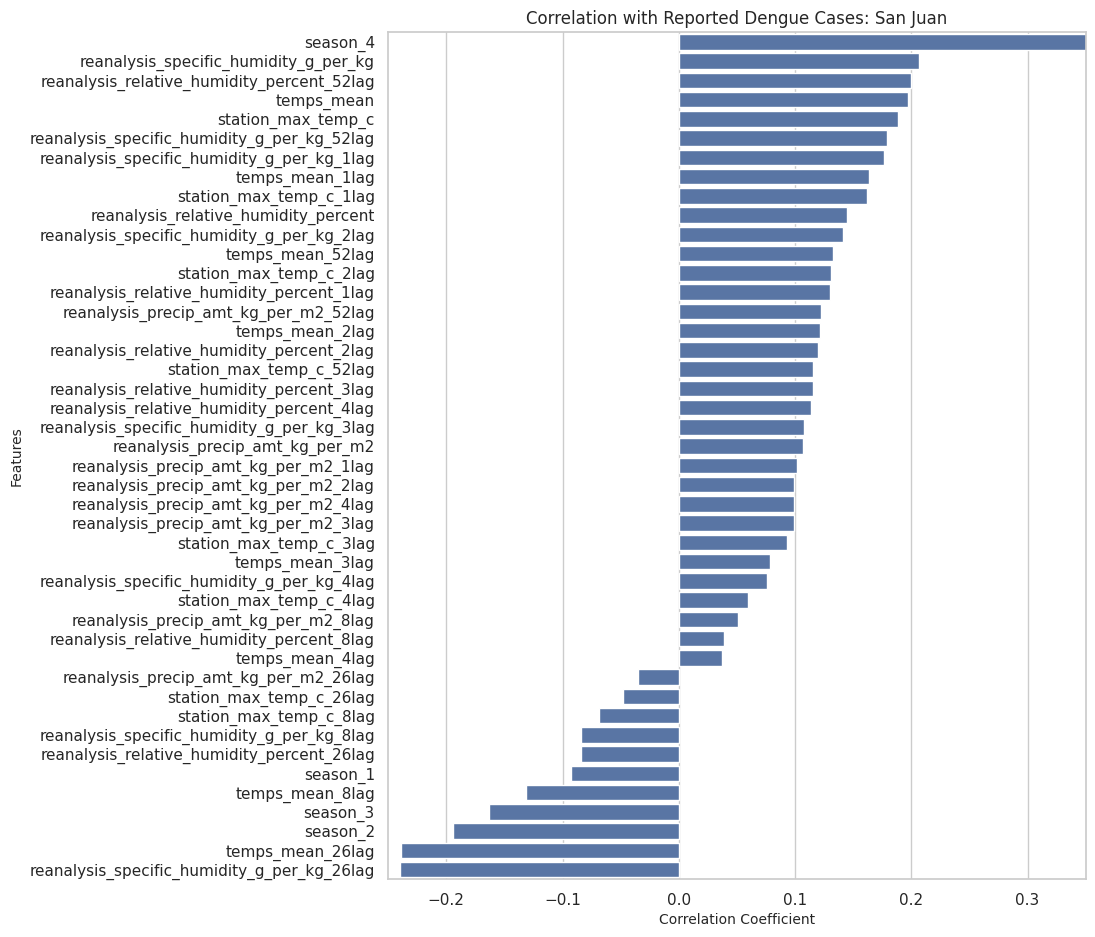

In [ ]:
# Drop the 'city' column and calculate correlation for San Juan
sjcorr = sj.corr().total_cases.drop(['total_cases'], axis=0).sort_values(ascending=False)

# Plot correlations for San Juan
plt.figure(figsize=[9, 11])
plt.title('Correlation with Reported Dengue Cases: San Juan', size=12)
sns.barplot(x=sjcorr, y=sjcorr.index)
plt.xlim([-.25, .35])
plt.xlabel('Correlation Coefficient', size=10)
plt.ylabel('Features', size=10)
plt.show()

feature engineered features seem to show higher corelation magnitude than original features

In [ ]:
#Split
sj_X = sj.drop(['total_cases'], axis=1)
sj_y = sj.total_cases

X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(
    sj_X, sj_y, test_size=0.3)
print(X_train_sj.shape)
print(X_test_sj.shape)

(655, 44)
(281, 44)


## Iquitos

In [ ]:
iq = rawfeats[rawfeats.city=='iq'].copy()
print(iq.shape)

(520, 25)


In [ ]:
def process_IQ(rawfeats, train=True):
    '''Returns a dataset ready for training or prediction'''
    #Fix Week Numbers
    if train:
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2005,
                                                      rawfeats.weekofyear+1, rawfeats.weekofyear)
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2006,
                                                      rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2010,
                                                      rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear'] = np.where(rawfeats.weekofyear_fixed>52,
                                                      1, rawfeats.weekofyear_fixed)
    else:
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2011,
                                                      rawfeats.weekofyear+1, rawfeats.weekofyear)
        rawfeats.loc[:,'weekofyear_fixed'] = np.where(rawfeats.year==2012,
                                                      rawfeats.weekofyear_fixed+1, rawfeats.weekofyear_fixed)
        rawfeats.loc[:,'weekofyear'] = np.where(rawfeats.weekofyear_fixed>52,
                                                      1, rawfeats.weekofyear_fixed)



    #Fill nas with interpolation
    feats = rawfeats.interpolate(method='linear')


    #season features
    cutoffs = [12, 24, 36]
    feats['fall'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)

    feats['winter'] = np.where((feats.weekofyear>=cutoffs[0]) &
                               (feats.weekofyear<cutoffs[1]), 1, 0)
    feats['spring'] = np.where((feats.weekofyear>=cutoffs[1]) &
                               (feats.weekofyear<cutoffs[2]), 1, 0)
    feats['summer'] = np.where((feats.weekofyear>=cutoffs[2]), 1, 0)


    #drop unneeded columns
    keep = ['total_cases',
       'spring', 'summer', 'fall', 'winter', 'station_avg_temp_c',
       'reanalysis_min_air_temp_k','station_min_temp_c',
       'reanalysis_dew_point_temp_k','reanalysis_tdtr_k',
       'reanalysis_specific_humidity_g_per_kg',
       'precipitation_amt_mm']

    for col in feats.columns:
        if col not in keep:
            feats = feats.drop(col, axis=1)

    #add shifted feats, w.r.t weeks
    to_shift = ['station_avg_temp_c','reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k',
       'reanalysis_specific_humidity_g_per_kg','precipitation_amt_mm']

    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
        feats[i+'_3lag'] = feats[i].shift(-3)
        feats[i+'_4lag'] = feats[i].shift(-4)
        feats[i+'_8lag'] = feats[i].shift(-8)
        feats[i+'_26lag'] = feats[i].shift(-26)
        feats[i+'_52lag'] = feats[i].shift(-52)
    feats = feats.fillna(method='ffill')
    return feats

In [ ]:
iq = process_IQ(iq)
iq.shape

(520, 61)

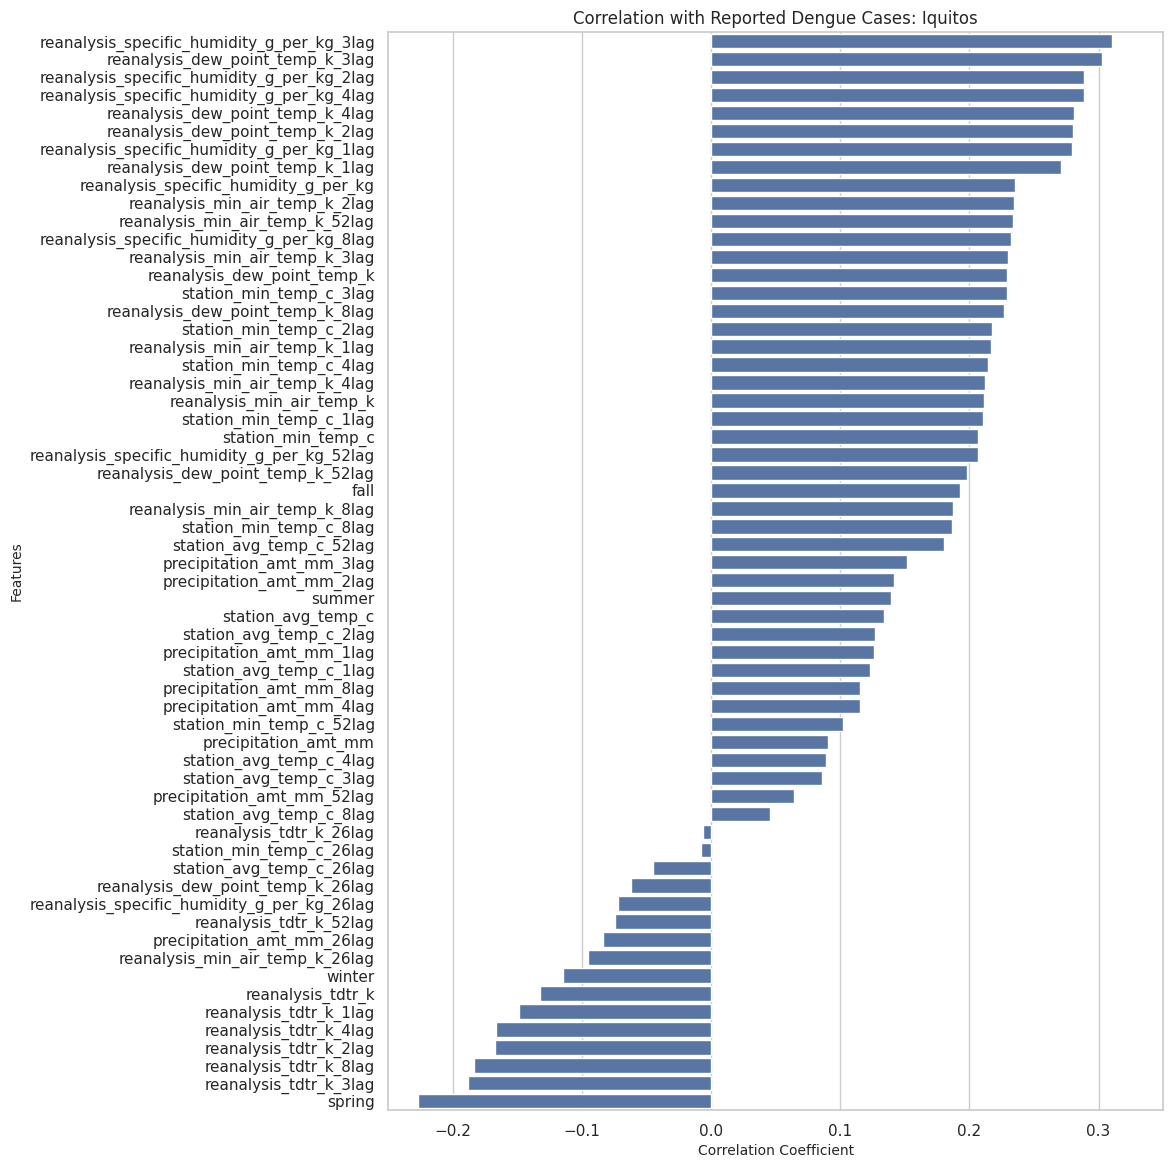

In [ ]:
# Drop the 'city' column and calculate correlation for San Juan
iqcorr = iq.corr().total_cases.drop(['total_cases'], axis=0).sort_values(ascending=False)

# Plot correlations for San Juan
plt.figure(figsize=[10, 14])
plt.title('Correlation with Reported Dengue Cases: Iquitos', size=12)
sns.barplot(x=iqcorr, y=iqcorr.index)
plt.xlim([-.25, .35])
plt.xlabel('Correlation Coefficient', size=10)
plt.ylabel('Features', size=10)
plt.show()

In [ ]:
iq_X = iq.drop(['total_cases'], axis=1)
iq_y = iq.total_cases

X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(
    iq_X, iq_y, test_size=0.3)
print(X_train_iq.shape)
print(X_test_iq.shape)


(364, 60)
(156, 60)


# Modelling & Hyperparamter tuning

In [ ]:
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np


# Define the parameters we want to cycle through
param_distributions = {
    'max_depth': [10, 15, 25, 35],
    'max_features': [2, 5, 'auto'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 200, 300],
}



## Tuning For San Jaun

In [ ]:

# start = time.time()
# rfr = RandomForestRegressor(criterion='absolute_error')

# # Randomized search for hyperparameter tuning
# random_search = RandomizedSearchCV(estimator=rfr,
#                                    param_distributions=param_distributions,
#                                    n_iter=50,  # Number of random combinations to try
#                                    cv=3,
#                                    n_jobs=-1,
#                                    random_state=42)

# # Fit the randomized search to data for SJ (Time Consuming)
# random_search.fit(X_train_sj, y_train_sj)
# print(time.time() - start)

# # Best parameters
# sj_rf_params = random_search.best_params_
# print(sj_rf_params)


In [ ]:
#best params for San Juan
sj_rf_params =  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 5, 'max_depth': 15}


In [ ]:
# start = time.time()

# rfr = RandomForestRegressor(criterion='absolute_error')

# # Randomized search for hyperparameter tuning
# random_search = RandomizedSearchCV(estimator=rfr,
#                                    param_distributions=param_distributions,
#                                    n_iter=50,  # Number of random combinations to try
#                                    cv=3,
#                                    n_jobs=-1,
#                                    random_state=42)

# # Fit the randomized search to data for SJ (Time Consuming)
# random_search.fit(X_train_iq, y_train_iq)
# print(time.time() - start)

# # Best parameters
# iq_rf_params = random_search.best_params_
# print(iq_rf_params)


In [ ]:
# Best Paramters for Iquitos

iq_rf_params = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 15}



# Final Training and  Predicting

In [ ]:
sj_rfr = RandomForestRegressor(**sj_rf_params, criterion='absolute_error')
iq_rfr = RandomForestRegressor(**iq_rf_params, criterion='absolute_error')

In [ ]:
sj_rfr.fit(sj_X, sj_y)

iq_rfr.fit(iq_X, iq_y)
print('Training Complete!')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Training Complete!


### Test Data processing and prediction using Random Forest

In [ ]:
testdata = pd.read_csv('/content/dengue_features_test.csv')

In [ ]:
sj_test = testdata[testdata.city=='sj'].copy()
sj_test = process_SJ(sj_test, train=False)
sj_test.shape

(260, 44)

In [ ]:
iq_test = testdata[testdata.city=='iq'].copy()
iq_test = process_IQ(iq_test)
iq_test.shape

(156, 60)

In [ ]:
sj_pred = sj_rfr.predict(sj_test).astype(int)
iq_pred = iq_rfr.predict(iq_test).astype(int)

In [ ]:
#Confirm no negative predictions
print(np.min(sj_pred))
print(np.min(iq_pred))

10
1


In [ ]:
submission = pd.read_csv('/content/submission_format.csv',
                            index_col=[0, 1, 2])

In [ ]:
import os

In [ ]:
from google.colab import files
submission.total_cases = np.concatenate([sj_pred, iq_pred])
submission.to_csv("/content/RFR_Predictions.csv")